In [1]:
%matplotlib inline

import time
import datetime

import pandas as pd
import matplotlib.pylab as plt
import numpy as np

from scipy.optimize import curve_fit
from jupyterthemes import jtplot

jtplot.style(theme='onedork')

In [2]:
# Data from:
# https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series

url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'

In [3]:
df = pd.read_csv(url, index_col=[0,1])
df

Lat       Long  \
Province/State            Country/Region                                
NaN                       Afghanistan            33.000000  65.000000   
                          Albania                41.153300  20.168300   
                          Algeria                28.033900   1.659600   
                          Andorra                42.506300   1.521800   
                          Angola                -11.202700  17.873900   
...                                                    ...        ...   
Saint Pierre and Miquelon France                 46.885200 -56.315900   
NaN                       South Sudan             6.877000  31.307000   
                          Western Sahara         24.215500 -12.885800   
                          Sao Tome and Principe   0.186360   6.613081   
                          Yemen                  15.552727  48.516388   

                                                 1/22/20  1/23/20  1/24/20  \
Province/State            Country/Region                                     
NaN                       Afghanistan                  0        0        0   
                          Albania                      0        0        0   
                          Algeria                      0        0        0   
                          Andorra                      0        0        0   
                          Angola                       0        0        0   
...                                                  ...      ...      ...   
Saint Pierre and Miquelon France                       0        0        0   
NaN                       South Sudan                  0        0        0   
                          Western Sahara               0        0        0   
                          Sao Tome and Principe        0        0        0   
                          Yemen                        0        0        0   

                                                 1/25/20  1/26/20  1/27/20  \
Province/State            Country/Region                                     
NaN                       Afghanistan                  0        0        0   
                          Albania                      0        0        0   
                          Algeria                      0        0        0   
                          Andorra                      0        0        0   
                          Angola                       0        0        0   
...                                                  ...      ...      ...   
Saint Pierre and Miquelon France                       0        0        0   
NaN                       South Sudan                  0        0        0   
                          Western Sahara               0        0        0   
                          Sao Tome and Principe        0        0        0   
                          Yemen                        0        0        0   

                                                 1/28/20  1/29/20  ...  \
Province/State            Country/Region                           ...   
NaN                       Afghanistan                  0        0  ...   
                          Albania                      0        0  ...   
                          Algeria                      0        0  ...   
                          Andorra                      0        0  ...   
                          Angola                       0        0  ...   
...                                                  ...      ...  ...   
Saint Pierre and Miquelon France                       0        0  ...   
NaN                       South Sudan                  0        0  ...   
                          Western Sahara               0        0  ...   
                          Sao Tome and Principe        0        0  ...   
                          Yemen                        0        0  ...   

                                                 4/4/20  4/5/20  4/6/20  \
Province/State            Country/Reg

In [4]:
df2 = df.drop(['Lat', 'Long'], 1).groupby(level=1).sum().T
df2.index = pd.to_datetime(df2.index)
last_date = df2.index[-1]

df2

Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,West Bank and Gaza,Western Sahara,Yemen,Zambia,Zimbabwe
2020-01-22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-26,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-09,15,23,235,25,2,2,72,10,51,295,...,7993,7,3,9,0,1,0,0,1,3
2020-04-10,15,23,256,26,2,2,82,12,54,319,...,8974,7,3,9,0,2,0,0,2,3
2020-04-11,18,23,275,26,2,2,83,13,57,337,...,9892,7,4,9,0,2,0,0,2,3
2020-04-12,18,23,293,29,2,2,90,13,60,350,...,10629,7,4,9,0,2,0,0,2,3


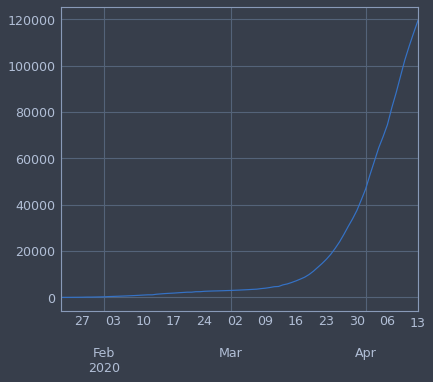

In [5]:
df2.T.sum().plot()

In [6]:
len(df2.columns)

185

In [7]:
df_exchina = df2.drop('China', 1)
df_exchina = df_exchina[df_exchina.T.sum() > 1]
len(df_exchina.columns)

184

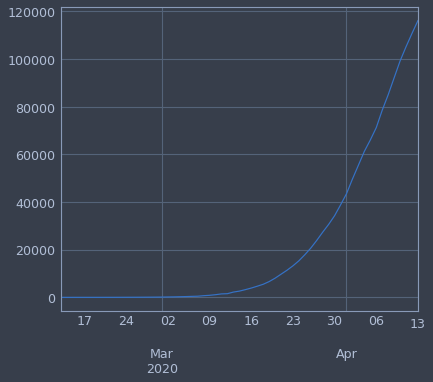

In [8]:
df_exchina.T.sum().plot()

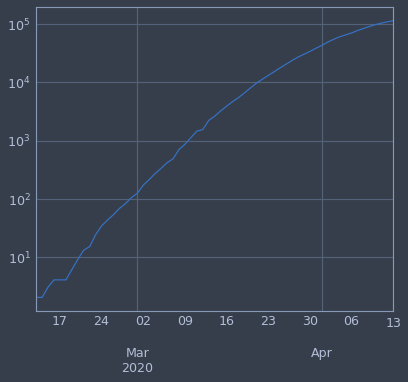

In [9]:
df_exchina.T.sum().plot(logy = True)

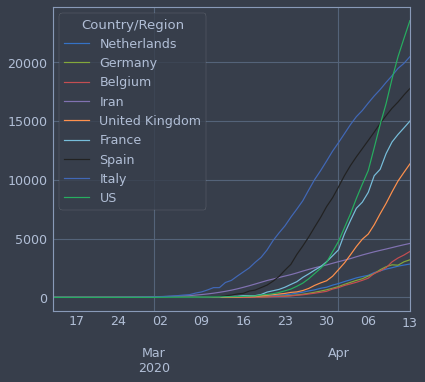

In [10]:
df_exchina.T.sort_values(by=last_date).tail(9).T.plot()

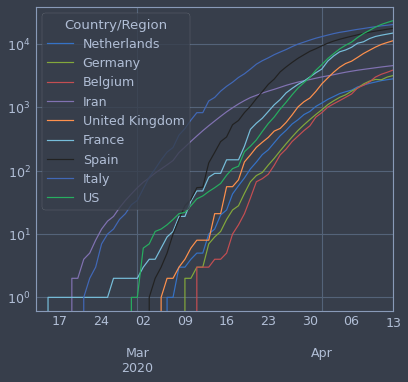

In [11]:
df_exchina.T.sort_values(by=last_date).tail(9).T.plot(logy = True)

In [12]:
df_exchina.T.sort_values(by=last_date).tail(9).T.tail(10)

Country/Region,Netherlands,Germany,Belgium,Iran,United Kingdom,France,Spain,Italy,US
2020-04-04,1656,1444,1283,3452,4320,7574,11947,15362,8407
2020-04-05,1771,1584,1447,3603,4943,8093,12641,15887,9619
2020-04-06,1874,1810,1632,3739,5385,8926,13341,16523,10783
2020-04-07,2108,2016,2035,3872,6171,10343,14045,17127,12722
2020-04-08,2255,2349,2240,3993,7111,10887,14792,17669,14695
2020-04-09,2403,2607,2523,4110,7993,12228,15447,18279,16478
2020-04-10,2520,2767,3019,4232,8974,13215,16081,18849,18586
2020-04-11,2653,2736,3346,4357,9892,13851,16606,19468,20463
2020-04-12,2747,3022,3600,4474,10629,14412,17209,19899,22020
2020-04-13,2833,3194,3903,4585,11347,14986,17756,20465,23529


In [13]:
df_exchina.T.sort_values(by=last_date).tail(9).T.diff().tail(10)

Country/Region,Netherlands,Germany,Belgium,Iran,United Kingdom,France,Spain,Italy,US
2020-04-04,166.0,169.0,140.0,158.0,709.0,1054.0,749.0,681.0,1320.0
2020-04-05,115.0,140.0,164.0,151.0,623.0,519.0,694.0,525.0,1212.0
2020-04-06,103.0,226.0,185.0,136.0,442.0,833.0,700.0,636.0,1164.0
2020-04-07,234.0,206.0,403.0,133.0,786.0,1417.0,704.0,604.0,1939.0
2020-04-08,147.0,333.0,205.0,121.0,940.0,544.0,747.0,542.0,1973.0
2020-04-09,148.0,258.0,283.0,117.0,882.0,1341.0,655.0,610.0,1783.0
2020-04-10,117.0,160.0,496.0,122.0,981.0,987.0,634.0,570.0,2108.0
2020-04-11,133.0,-31.0,327.0,125.0,918.0,636.0,525.0,619.0,1877.0
2020-04-12,94.0,286.0,254.0,117.0,737.0,561.0,603.0,431.0,1557.0
2020-04-13,86.0,172.0,303.0,111.0,718.0,574.0,547.0,566.0,1509.0


In [14]:
df_exchina.T.sort_values(by=last_date).tail(9).T.diff().diff().tail(10)

Country/Region,Netherlands,Germany,Belgium,Iran,United Kingdom,France,Spain,Italy,US
2020-04-04,17.0,1.0,8.0,24.0,24.0,-68.0,-101.0,-85.0,159.0
2020-04-05,-51.0,-29.0,24.0,-7.0,-86.0,-535.0,-55.0,-156.0,-108.0
2020-04-06,-12.0,86.0,21.0,-15.0,-181.0,314.0,6.0,111.0,-48.0
2020-04-07,131.0,-20.0,218.0,-3.0,344.0,584.0,4.0,-32.0,775.0
2020-04-08,-87.0,127.0,-198.0,-12.0,154.0,-873.0,43.0,-62.0,34.0
2020-04-09,1.0,-75.0,78.0,-4.0,-58.0,797.0,-92.0,68.0,-190.0
2020-04-10,-31.0,-98.0,213.0,5.0,99.0,-354.0,-21.0,-40.0,325.0
2020-04-11,16.0,-191.0,-169.0,3.0,-63.0,-351.0,-109.0,49.0,-231.0
2020-04-12,-39.0,317.0,-73.0,-8.0,-181.0,-75.0,78.0,-188.0,-320.0
2020-04-13,-8.0,-114.0,49.0,-6.0,-19.0,13.0,-56.0,135.0,-48.0


In [15]:
def sigmoid(x, sat, td, velo):
    x = np.float64(x)
    
    td *= 1e10
    td *= 1e9
    
    real_sat = 1e5 * sat
    x = x - td
    x /= 1e14
    return real_sat / (1 + np.exp(-x * velo))

x = df_exchina.index
sat = 30000 / 1e5
td = time.time() / 1e10
velo = .1

In [16]:
popt, pcov = curve_fit(f = sigmoid, 
                       xdata = df_exchina.index, 
                       ydata = df_exchina.T.sum(), 
                       p0 = (sat, td, velo)
                      )

In [17]:
y_fit = sigmoid(x, *list(popt))

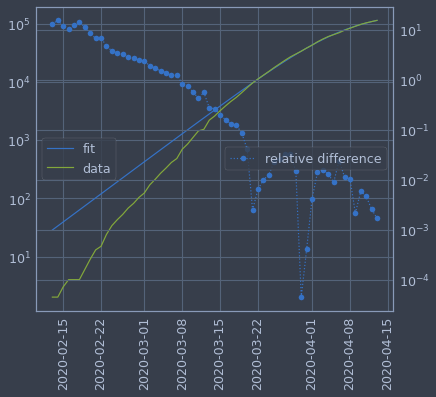

In [18]:
fig, ax1 = plt.subplots()
plt.xticks(rotation=90)


ax1.semilogy(x, y_fit, label="fit")
ax1.semilogy(x, df_exchina.T.sum(), label="data")

ax2 = ax1.twinx()
ax2.semilogy(x, abs(y_fit - df_exchina.T.sum())/df_exchina.T.sum(), "o:", label="relative difference")
# ax1.legend(loc="lower left")
# ax2.legend(loc="center left")
ax1.legend(loc="center left")
ax2.legend(loc="center right")

In [19]:
th = datetime.datetime.fromtimestamp(popt[1] * 1e10)

In [20]:
f'The total number of Deaths outside China due to Covid-19 will be {int(popt[0] * 1e5)}. Half of those will be reached at {th.strftime("%Y-%B-%d %H:%M")}'

'The total number of Deaths outside China due to Covid-19 will be 162655. Half of those will be reached at 2020-April-07 09:01'

In [21]:
th - df_exchina.index[-1]

Timedelta('-6 days +09:01:15.234746')

In [22]:
df_exchina.T.sum().tail()

2020-04-09     92116
2020-04-10     99185
2020-04-11    105160
2020-04-12    110748
2020-04-13    116137
dtype: int64

In [23]:
df_exchina.T.sum().diff().tail(10)

2020-04-04    5815.0
2020-04-05    4765.0
2020-04-06    5189.0
2020-04-07    7300.0
2020-04-08    6471.0
2020-04-09    7115.0
2020-04-10    7069.0
2020-04-11    5975.0
2020-04-12    5588.0
2020-04-13    5389.0
dtype: float64

In [24]:
tstart = min(df_exchina.index)
tend = tstart + (th - tstart) * 2

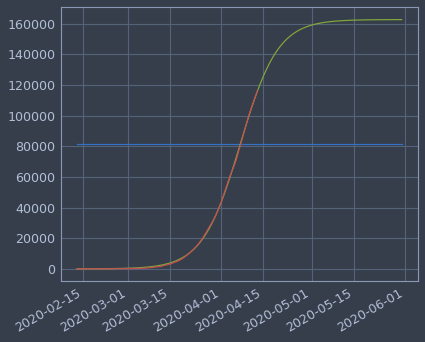

In [25]:
x_extra = np.arange(tstart, tend, datetime.timedelta(days=1)).astype('datetime64[ns]')
y_extra = sigmoid(x_extra, *list(popt))

plt.plot(x_extra, [popt[0]/2 * 1e5 for _ in x_extra])
plt.plot(x_extra, y_extra)
df_exchina.T.sum().plot()
plt.show()

(array([737470., 737477., 737485., 737492., 737499., 737506., 737516.,
        737523., 737530.]),
 <a list of 9 Text major ticklabel objects>)

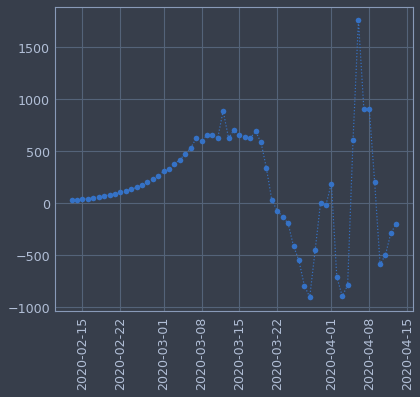

In [26]:
plt.plot(df_exchina.index, y_fit - df_exchina.T.sum(), ":o")
plt.xticks(rotation=90)

In [27]:
x = []
y_var = []
y = []
h = []

for e in df_exchina.index[30:]:
    df_temp = df_exchina[:e]
    
    popt, pcov = curve_fit(f = sigmoid, 
                       xdata = df_temp.index, 
                       ydata = df_temp.T.sum(), 
                       p0 = (sat, td, velo)
                      )
    
    x.append(e + datetime.timedelta(days=1))
    y_var.append(np.diag(pcov)[1] * 1e10)
    y.append(datetime.datetime.fromtimestamp(popt[1] * 1e10))
    h.append(int(popt[0] * 1e5))
    

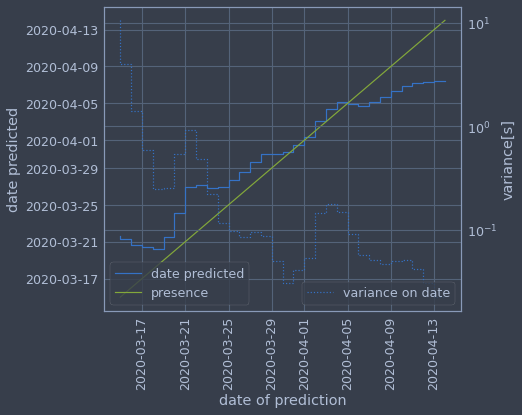

In [28]:
fig, ax1 = plt.subplots()
plt.xticks(rotation=90)
plt.xlabel("date of prediction")

plt.ylabel("date predicted")

ax1.plot(x, y, label='date predicted', drawstyle='steps')
ax1.plot(x, x, label='presence')


ax2 = ax1.twinx()
ax2.semilogy(x, y_var, ":", label='variance on date', drawstyle='steps')
plt.ylabel("variance[s]")

ax1.legend(loc="lower left")
ax2.legend(loc="lower right")

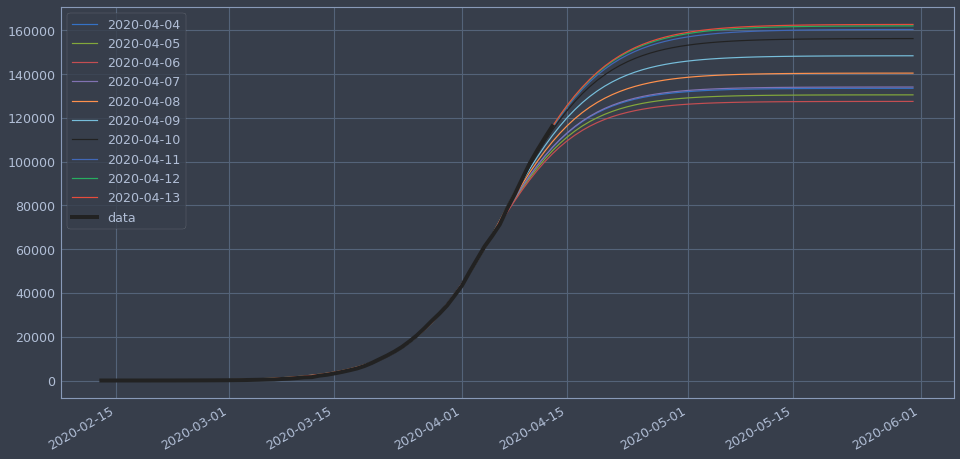

In [29]:
for e in df_exchina.index[-10:]:#[30:]:
    df_temp = df_exchina[:e]
    
    popt, pcov = curve_fit(f = sigmoid, 
                       xdata = df_temp.index, 
                       ydata = df_temp.T.sum(), 
                       p0 = (sat, td, velo)
                      )
    y_extra = sigmoid(x_extra, *list(popt))

    plt.plot(x_extra, y_extra, label=e.strftime("%Y-%m-%d"))
df_exchina.T.sum().plot(linewidth=4, style="k", label="data", figsize=(16,8))
plt.legend(loc="upper left")
plt.show()
    

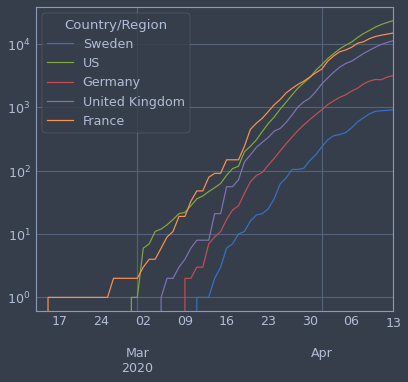

In [30]:
df_exchina[["Sweden", "US", "Germany", "United Kingdom", "France"]].plot(logy=True)